<a href="https://colab.research.google.com/github/Mutasar/Human_resource/blob/main/analisa_sentimen_ulasan_aplikasi_tokopedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import joblib
from google.colab import files


#2.inisialisasi dataset


  pada tahap inisialisasi dataset di Google Colab. Tahap ini adalah langkah awal yang krusial dalam proyek analisis data apa pun. Tujuannya adalah untuk memuat data ke dalam lingkungan kerja (dalam hal ini, Google Colab) dan melakukan pemeriksaan awal untuk memahami struktur dan karakteristiknya.

In [ ]:
# inisialisasi dataset
file_id = '1GLyhzyN3XNgmC3ftv4Klmvtlt_Dc7XzD'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Membaca CSV
df = pd.read_csv(download_url)

In [ ]:
df.head()

,userName,score,at,content
0,Pengguna Google,5,2024-09-08 03:31:50,makasih toped
1,Pengguna Google,1,2024-09-08 03:29:56,Aplikasi php sudah banyak dikasih promo &sudah...
2,Pengguna Google,5,2024-09-08 03:26:38,mantab... 👍
3,Pengguna Google,5,2024-09-08 03:25:14,Good good
4,Pengguna Google,1,2024-09-08 03:24:01,Sangat buruk sebagai pengguna lama akun affali...


In [ ]:
#Tampilkan informasi terkait dataset
df.info()

# Hitung jumlah kategori sentimen
df.content.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userName  500000 non-null  object
 1   score     500000 non-null  int64 
 2   at        500000 non-null  object
 3   content   499999 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


,count
content,
mantap,16427
Mantap,8386
bagus,7674
ok,7672
Bagus,7565
...,...
Andalanqueee,1
Kenapa produk2 Vape tidak keluar ya di aps android? Padahal login akun juga ada umur pemakainya.,1
Jelek Banget. Masa saldo refund minimal penarikan 50K. TERUS PARAHNYA SALDONYA GABISA DITOP UP. kesel bgt itumah namanya scam. Males bgt gw pake apk ini gajelas promo2 juga ttp aja ujungnya scam.,1


In [ ]:
# Menampilkan statistik deskriptif dataset dengan menjalankan describe

df.describe()

,score
count,500000.000000
mean,4.074004
std,1.545313
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
df = df.rename(columns={
    'userName': 'nama',
    'score': 'rating',
    'at': 'waktu',
    'content': 'ulasan'
})
print(df.columns)

Index(['nama', 'rating', 'waktu', 'ulasan'], dtype='object')


Insight dari Tahap Inisialisasi Dataset:

Dari langkah-langkah ini, kita mendapatkan beberapa wawasan penting tentang data ulasan Tokopedia Anda sebelum memulai proses pembersihan atau analisis mendalam:

Sumber Data dan Format: Data berasal dari file CSV yang diunduh dari Google Drive. Ini mengkonfirmasi format data (tabular) dan cara aksesnya.
Kolom yang Tersedia: Dataset berisi informasi tentang userName, score, at, dan content. Ini adalah kolom-kolom utama yang akan Anda gunakan:
content (sekarang ulasan): Ini adalah teks ulasan yang akan menjadi fokus analisis sentimen.
score (sekarang rating): Ini adalah nilai numerik yang akan Anda gunakan sebagai dasar untuk pelabelan sentimen.
userName (sekarang nama) dan at (sekarang waktu): Ini adalah metadata ulasan yang mungkin berguna untuk analisis tambahan (misalnya, analisis tren waktu, analisis pengguna paling aktif), tetapi tidak secara langsung digunakan untuk klasifikasi sentimen berbasis teks di model Anda saat ini.
Tipe Data Awal: df.info() akan memberi tahu Anda tipe data awal. Kolom content/ulasan idealnya bertipe object (string). Kolom score/rating seharusnya bertipe numerik (int64 atau float64). Jika tipe datanya tidak sesuai (misalnya, rating terbaca sebagai object), itu akan menjadi masalah yang perlu ditangani di tahap pembersihan.
Ukuran Dataset Awal: df.info() akan menampilkan jumlah total baris (entri ulasan) dalam dataset. Ini memberikan gambaran awal tentang seberapa besar data yang Anda miliki.
Distribusi Rating Awal: df.describe() (untuk kolom rating) akan menunjukkan rentang rating (min, max) dan distribusi nilai (mean, median, kuartil). Misalnya, apakah rating cenderung tinggi (banyak 4s dan 5s) atau rendah (banyak 1s dan 2s)? Ini memberikan gambaran awal tentang sentimen keseluruhan berdasarkan rating sebelum analisis teks.
Potensi Data Hilang (Null Values): df.info() (dengan jumlah non-null) dan df.isnull().sum() (di bagian pembersihan) secara eksplisit mengidentifikasi kolom mana yang memiliki data yang hilang. Ini adalah wawasan kritis yang mengharuskan Anda melakukan penanganan nilai null di tahap pembersihan.
Potensi Data Duplikat: Langkah pengecekan df.duplicated().sum() segera setelah inisialisasi mengungkapkan apakah ada baris ulasan yang persis sama. Ini juga wawasan penting yang memerlukan penanganan di tahap pembersihan.

#3.Pembersihan Data

  Setelah dataset berhasil diinisialisasi dan Anda mendapatkan wawasan awal tentang kondisinya (terutama mengenai data hilang dan duplikat), tahap berikutnya yang sangat penting adalah Pembersihan Data.

In [ ]:
# Mengecek dataset menggunakan isnull().sum()

print("Cek nilai null:\n", df.isnull().sum())

Cek nilai null:
 userName    0
score       0
at          0
content     1
dtype: int64


In [ ]:
df.dropna()

,userName,score,at,content
0,Pengguna Google,5,2024-09-08 03:31:50,makasih toped
1,Pengguna Google,1,2024-09-08 03:29:56,Aplikasi php sudah banyak dikasih promo &sudah...
2,Pengguna Google,5,2024-09-08 03:26:38,mantab... 👍
3,Pengguna Google,5,2024-09-08 03:25:14,Good good
4,Pengguna Google,1,2024-09-08 03:24:01,Sangat buruk sebagai pengguna lama akun affali...
...,...,...,...,...
499995,Aara Nindya,5,2021-03-24 14:15:11,Sangat bagus
499996,Fitri Afnita yanti,5,2021-03-24 14:15:09,dengan aplikasi ini saya mudah2 saya bisa menj...
499997,Siti Aisyah,5,2021-03-24 14:14:49,sangat membantu
499998,Rohmat Gombik,5,2021-03-24 14:14:42,sangat memuaskan


In [ ]:
# Mengecek dataset menggunakan duplicated().sum()

print("\nJumlah duplikasi:", df.duplicated().sum())


Jumlah duplikasi: 10


In [ ]:
#menghilangkan data duplikat
df = df.drop_duplicates()

In [ ]:
#cek hasil drop duplikat
print("\nJumlah duplikasi:", df.duplicated().sum())


Jumlah duplikasi: 0


- insight dari tahap pembersihan data adalah pemahaman tentang:

  - Masalah Kualitas Data: Jenis ketidaksempurnaan apa yang ada dalam data mentah (nilai null, duplikat).
  - Metode Penanganan: Bagaimana masalah-masalah tersebut diatasi (mengisi nulls di teks, menghapus duplikat).
  - Dampak Positif: Bagaimana pembersihan ini meningkatkan kualitas data dan membuatnya siap untuk tahap-tahap analisis dan pemodelan selanjutnya, mengurangi risiko error dan meningkatkan keandalan hasil.

#4.Preparation data

- Case folding


In [ ]:
#Buat dataframe baru untuk menampung data yang sudah dilakukan preprocessing
clean_df = df.copy()

clean_df['ulasan'] = clean_df['ulasan'].str.lower()


- Word normalization


In [ ]:
# Buat dataframe baru untuk menampung data yang sudah dilakukan preprocessing
clean_df = df.copy()

# Convert the 'ulasan' column to string type, handling potential NaN values
clean_df['ulasan'] = clean_df['ulasan'].astype(str)

clean_df['ulasan'] = clean_df['ulasan'].str.lower()

# ... rest of your code for word normalization
# Import regular expression library
import re

word_mapping = {
    "yg": "yang","tp": "tapi","bgt": "begitu","jg": "juga","dgn": "dengan","pake": "pakai","jd": "jadi","klo": "kalo",
    "lg": "lagi","dr": "dari","utk": "untuk","gk": "tidak","sdh": "sudah","ngga": "tidak","brg": "barang","ga": "tidak",
    "gak": "tidak","rapi": "rapih","cpt": "cepat","krn": "karena","sy": "saya","tdk": "tidak","nggak": "tidak","kalo": "kalau",
    "cepet": "cepat","pake": "pakai","gitu": "begitu","udh": "udah","d": "di","g" : "tidak","tgl": "tanggal","pake": "pakai",
    "sampe": "sampai","mantab": "mantap"
    # Add more mappings as needed
}

# Define a function to replace shortened words using re.sub
def normalize_word(text):
    # Create a regex pattern from the keys of the word_mapping dictionary
    pattern = r'\b(' + '|'.join(re.escape(word) for word in word_mapping.keys()) + r')\b'

    # Define a function to replace matches with their corresponding values from the dictionary
    def replace(match):
        return word_mapping[match.group(0)]

    # Use re.sub with the pattern and the replace function
    normalized_text = re.sub(pattern, replace, text)

    return normalized_text

clean_df['ulasan'] = clean_df['ulasan'].apply(normalize_word)

- Menghapus stopwords
  - langkah penting dalam praproses teks untuk menghilangkan kata-kata umum yang tidak terlalu membawa makna, seperti "dan", "yang", "itu", dll. Tujuannya adalah:

  - Mengurangi dimensi data.

  - Fokus pada kata-kata yang lebih penting untuk analisis sentimen atau klasifikasi.



In [ ]:
# Unduh data stop words dan punkt jika belum
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Membuat set stop words Bahasa Indonesia

stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghapus stop words
def remove_stopwords(text):
    # Pastikan input adalah string (penanganan NaN seperti sebelumnya)
    if not isinstance(text, str):
        return ''
    # Menghapus stop words
    filtered_tokens = [word for word in Tokens if word not in stop_words]

    # Menggabungkan kembali token menjadi string
    return " ".join(filtered_tokens)

- Tokenisasi

  tokenisasi memecah teks menjadi bagian-bagian yang lebih kecil untuk analisis mesin yang lebih mudah, membantu mesin memahami bahasa manusia

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Membuat set stop words Bahasa Indonesia (pastikan NLTK diunduh)
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghapus stop words dan melakukan tokenisasi
def tokenize_and_remove_stopwords(text):
    if not isinstance(text, str):
        return [] # Kembalikan list kosong jika bukan string

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens # Mengembalikan list token


In [ ]:
# Remove stopwords
stop_words = set(stop_words)

def remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]  # Remove stopwords
    cleaned_text = ' '.join(filtered_tokens)  # Join filtered tokens back into a cleaned text
    return cleaned_text.strip()  # Strip leading and trailing spaces

clean_df['ulasan'] = clean_df['ulasan'].apply(remove_stopwords)

In [ ]:
# Split the dataframe into positive and negative only
df_vis_pos = df[df['ulasan'] == "Positive"]
df_vis_neg = df[df['ulasan'] == "Negative"]

In [ ]:
# Definisikan fungsi pelabelan sentimen berdasarkan rating
def get_label(rating):
        if rating >= 4:
            return 1  # Positif
        elif rating <= 3:
            return 0  # Negatif
        else:
            return None  # Jika rating tidak valid

# Terapkan fungsi get_label ke kolom 'rating' dan simpan hasilnya di kolom baru 'label'
df['label'] = df['rating'].apply(get_label)

# Tampilkan beberapa baris pertama DataFrame untuk melihat kolom 'label' yang baru
print(df.head())

# Hitung distribusi label untuk melihat jumlah ulasan positif dan negatif
print("\nDistribusi label sentimen:")
print(df["label"].value_counts())

              nama  rating                waktu  \
0  Pengguna Google       5  2024-09-08 03:31:50   
1  Pengguna Google       1  2024-09-08 03:29:56   
2  Pengguna Google       5  2024-09-08 03:26:38   
3  Pengguna Google       5  2024-09-08 03:25:14   
4  Pengguna Google       1  2024-09-08 03:24:01   

                                              ulasan  label  
0                                      makasih toped      1  
1  Aplikasi php sudah banyak dikasih promo &sudah...      0  
2                                        mantab... 👍      1  
3                                          Good good      1  
4  Sangat buruk sebagai pengguna lama akun affali...      0  

Distribusi label sentimen:
label
1    379625
0    120365
Name: count, dtype: int64


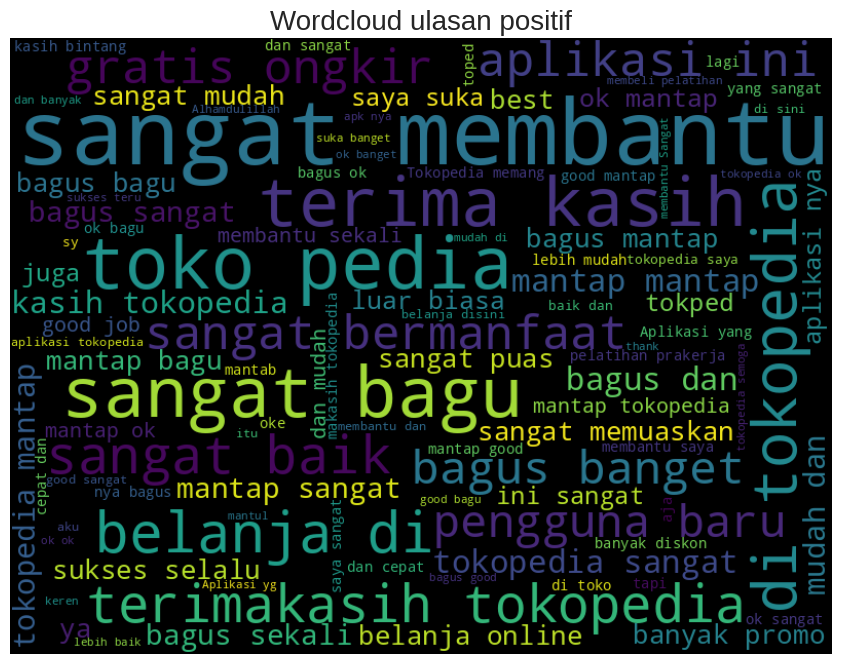

In [ ]:

# Split the dataframe into positive and negative based on the 'label' column
df_vis_pos = df[df['label'] == 1]  # Use label 1 for positive
df_vis_neg = df[df['label'] == 0]  # Use label 0 for negative

# Create WordCloud plot for positive reviews
txt_pos = ' '.join(rev for rev in df_vis_pos['ulasan'].astype(str)) # Use the actual review text
plt.figure(figsize=(15,8))
wordcloud_pos = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 600
            ).generate(txt_pos) # Generate from the positive text

plt.imshow(wordcloud_pos,interpolation = 'bilinear')
plt.axis('off')
plt.title(label="Wordcloud ulasan positif", fontsize=20)
plt.show()



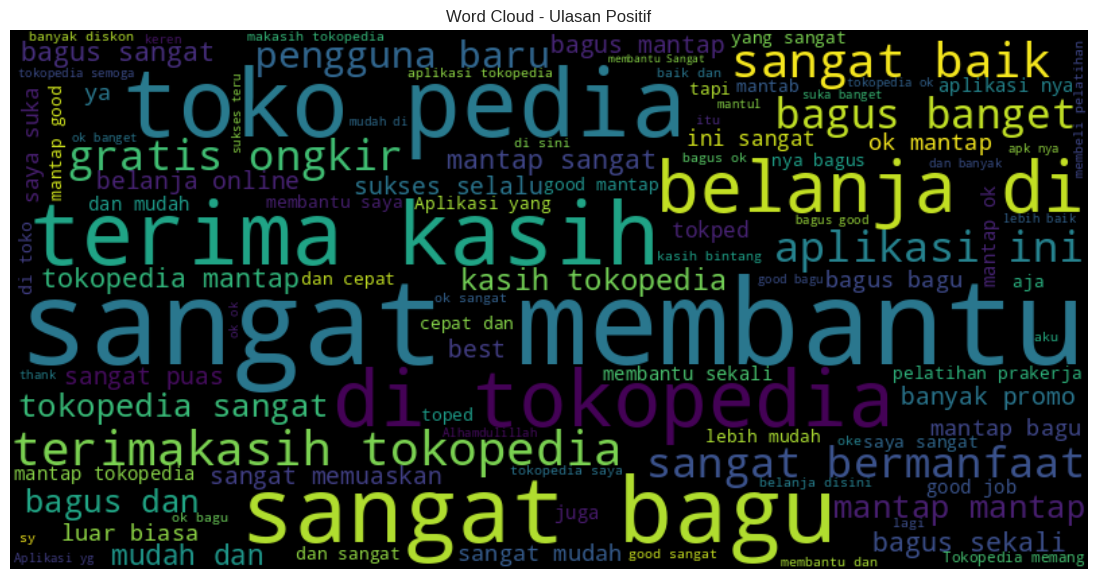

In [ ]:

# Misal: ambil hanya ulasan positif
df_vis_pos = df[df['label'] == 1]  # label 1 = positif

# Gabungkan semua teks jadi satu string
txt_pos = ' '.join(df_vis_pos['ulasan'].astype(str))

# Buat wordcloud
wordcloud_pos = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100,
    width=800,
    height=400
).generate(txt_pos)

# Tampilkan
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Ulasan Positif")
plt.show()


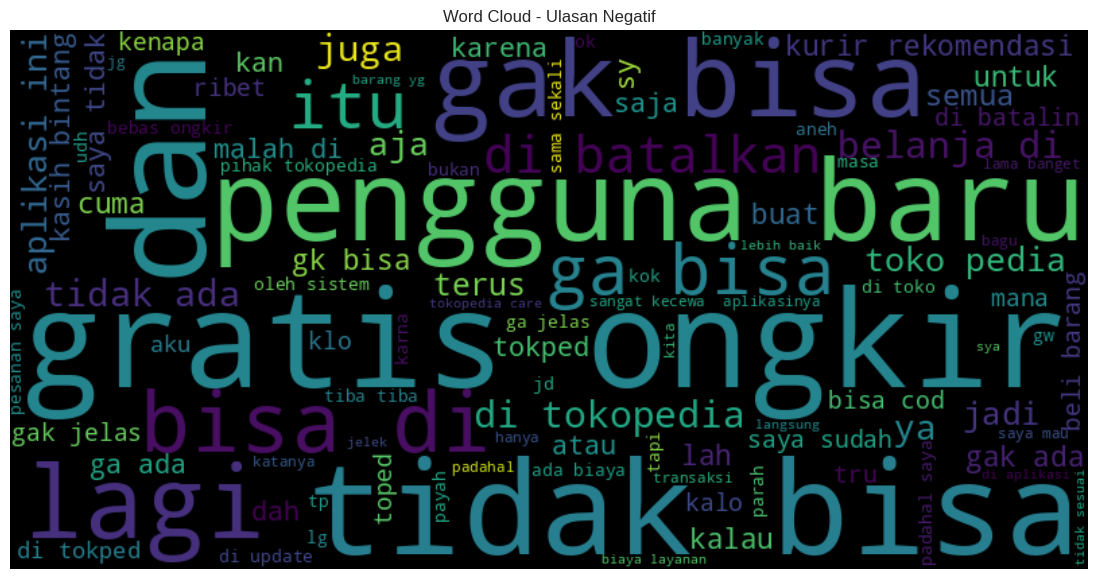

In [ ]:
#Misal: ambil hanya ulasan positif
df_vis_pos = df[df['label'] == 0]  # label 1 = positif

# Gabungkan semua teks jadi satu string
txt_pos = ' '.join(df_vis_pos['ulasan'].astype(str))

# Buat wordcloud
wordcloud_pos = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100,
    width=800,
    height=400
).generate(txt_pos)

# Tampilkan
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Ulasan Negatif")
plt.show()


#5.Model



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Ambil data teks dan label
texts = df['ulasan'].astype(str).values
labels = df['label'].values

# Split training dan testing
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenisasi
vocab_size = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_train)

X_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=maxlen, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(texts_test), maxlen=maxlen, padding='post')
y_train = np.array(labels_train).astype('float32')
y_test = np.array(labels_test).astype('float32')

In [ ]:
from tensorflow.keras.optimizers import Adam
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

#melatih model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 919s 92ms/step - accuracy: 0.7700 - loss: 0.5195 - val_accuracy: 0.7561 - val_loss: 0.4801
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 908s 91ms/step - accuracy: 0.7604 - loss: 0.4760 - val_accuracy: 0.7561 - val_loss: 0.4741
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 919s 90ms/step - accuracy: 0.7597 - loss: 0.4722 - val_accuracy: 0.7561 - val_loss: 0.4793
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 919s 90ms/step - accuracy: 0.7591 - loss: 0.4747 - val_accuracy: 0.7561 - val_loss: 0.4808
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 923s 90ms/step - accuracy: 0.7604 - loss: 0.4767 - val_accuracy: 0.7561 - val_loss: 0.4780


In [ ]:
#evaluasi model

oss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi pada data test: {accuracy:.4f}")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.7592 - loss: 0.4759
Akurasi pada data test: 0.7590


In [ ]:
#predisi ulasan baru


def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=maxlen, padding='post')
    prediction = model.predict(padded)[0][0]
    return "Positif" if prediction >= 0.5 else "Negatif"


insight dari tahap Pelabelan Sentimen adalah pemahaman tentang bagaimana data rating numerik diubah menjadi label kategorikal untuk klasifikasi, apa definisi operasional sentimen dalam proyek Anda, dan bagaimana distribusi kelas dalam dataset yang sudah dilabeli. Ini sangat penting untuk memilih metrik evaluasi yang tepat dan merencanakan langkah-langkah persiapan data selanjutnya jika dataset tidak seimbang.

# 5.Tokenisasi & Padding

  Tokenisasi & Padding ini sangat penting ketika menggunakan model Deep Learning (seperti LSTM atau model berbasis sequence lainnya) untuk teks. Model-model ini memerlukan input data yang memiliki panjang yang seragam.

In [ ]:
# Kumpulan teks yang sudah dibersihkan
teks = [
    "produk bagus murah",
    "sangat tidak puas",
    "pengiriman cepat aman",
    "buruk lambat rusak",
]

# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(teks)

# Tokenisasi
sekuens = tokenizer.texts_to_sequences(teks)

# Padding (panjang disamakan)
padded = pad_sequences(sekuens, maxlen=6, padding='post')

# Tampilkan hasil
print("Word Index:", tokenizer.word_index)
print("Sekuens:", sekuens)
print("Padded:", padded)

Word Index: {'<OOV>': 1, 'produk': 2, 'bagus': 3, 'murah': 4, 'sangat': 5, 'tidak': 6, 'puas': 7, 'pengiriman': 8, 'cepat': 9, 'aman': 10, 'buruk': 11, 'lambat': 12, 'rusak': 13}
Sekuens: [[2, 3, 4], [5, 6, 7], [8, 9, 10], [11, 12, 13]]
Padded: [[ 2  3  4  0  0  0]
 [ 5  6  7  0  0  0]
 [ 8  9 10  0  0  0]
 [11 12 13  0  0  0]]


insight dari tahap Tokenisasi & Padding adalah pemahaman tentang bagaimana data teks disiapkan menjadi format numerik berdimensi tetap yang dibutuhkan oleh model Deep Learning, termasuk keputusan penting mengenai ukuran kosakata, penanganan panjang urutan, dan penerapan proses hanya pada data pelatihan untuk mencegah data leakage.



In [ ]:
# Simpan DataFrame ke file CSV
# index=False mencegah Pandas menulis indeks DataFrame sebagai kolom di CSV
df.to_csv('nama_file_output.csv', index=False)

# Download file CSV ke komputer lokal Anda
files.download('nama_file_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6.Model Deep Learning (LSTM)


Tahap Model Deep Learning (LSTM) adalah di mana Anda mendefinisikan arsitektur jaringan saraf yang akan belajar mengklasifikasikan sentimen ulasan. Anda memilih Long Short-Term Memory (LSTM), yang merupakan jenis Recurrent Neural Network (RNN) yang sangat efektif untuk memproses data urutan seperti teks.

In [ ]:
texts = df['ulasan']  # atau df['clean_text'] jika itu kolom teksnya
labels = df['label']  # atau df['sentimen'] jika itu labelnya

In [ ]:
# Ambil teks dan label dari dataset
texts = df['ulasan'].astype(str).values
labels = df['rating'].values

In [ ]:
# Split data: training dan testing
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)
train_sequences = tokenizer.texts_to_sequences(texts_train)
test_sequences = tokenizer.texts_to_sequences(texts_test)


In [ ]:
# Padding
maxlen = 100
X_train = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
X_test = pad_sequences(test_sequences, maxlen=maxlen, padding='post')


In [ ]:
# Konversi label ke float
y_train = np.array(labels_train).astype('float32')
y_test = np.array(labels_test).astype('float32')

insight dari tahap Model Deep Learning (LSTM) adalah pemahaman tentang bagaimana arsitektur jaringan saraf dipilih dan dirancang untuk secara efektif memproses data urutan teks, memanfaatkan representasi embedding yang belajar, menangkap dependensi kontekstual menggunakan LSTM, dan dikonfigurasi dengan tepat untuk tugas klasifikasi sentimen biner

#7.Pelatihan Model

tahap Pelatihan Model Ini adalah proses iteratif di mana model Deep Learning Anda belajar dari data pelatihan untuk menyesuaikan bobot internalnya agar dapat memprediksi label sentimen dengan akurat.

In [ ]:


# Ambil data teks dan label
texts = df['ulasan'].astype(str).values
labels = df['label'].values

# Split training dan testing
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenisasi
vocab_size = 10000  # This is where vocab_size is defined
maxlen = 100      # This is where maxlen is defined

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_train)

X_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=maxlen, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(texts_test), maxlen=maxlen, padding='post')
y_train = np.array(labels_train).astype('float32')
y_test = np.array(labels_test).astype('float32')


Insight dari tahap pelatihan model adalah pemahaman tentang bagaimana model belajar dari data melalui proses iteratif yang didorong oleh optimasi loss, pentingnya memantau kinerja pada data validasi untuk mendeteksi overfitting, dan bagaimana hyperparameter pelatihan (seperti jumlah epoch) memengaruhi proses ini.

# 8.visualisasi hasil

visualisasi ini memberikan gambaran komprehensif tentang distribusi sentimen dan tema umum yang terkait dengan ulasan positif dan negatif dalam dataset Anda. Bar plot mengkuantifikasi tingkat sentimen keseluruhan, sementara word clouds menawarkan wawasan kualitatif tentang bahasa yang digunakan oleh pelanggan untuk setiap sentimen.

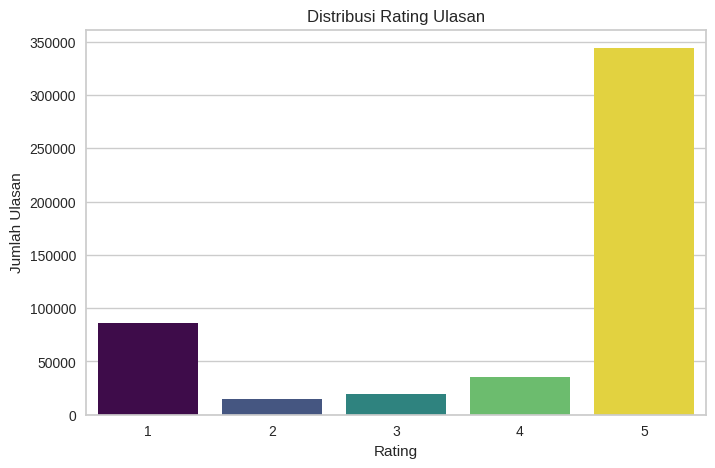

In [ ]:
plt.figure(figsize=(8, 5))
rating_counts = df['rating'].value_counts()
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis', hue=rating_counts.index, legend=False) # Added hue and legend=False
plt.title('Distribusi Rating Ulasan')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

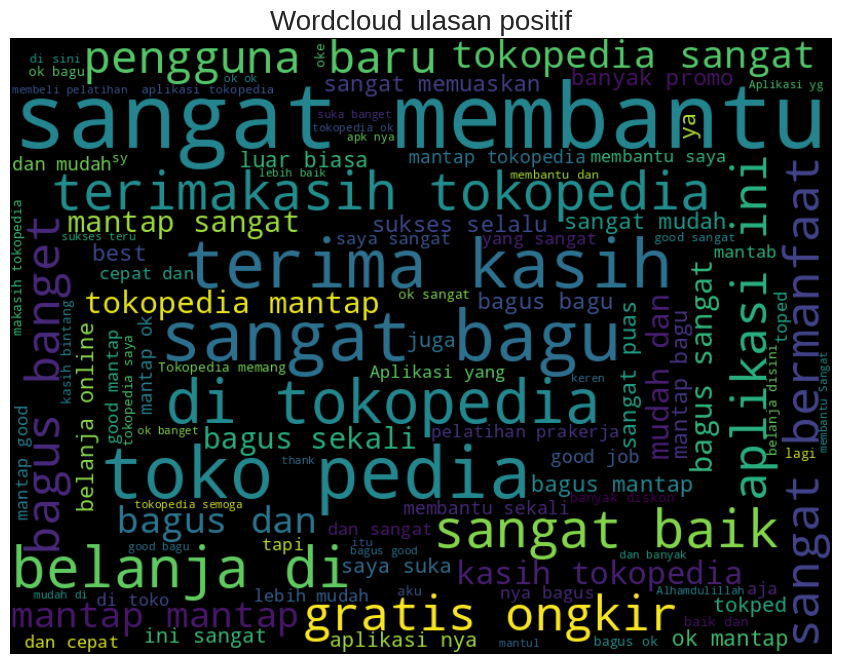

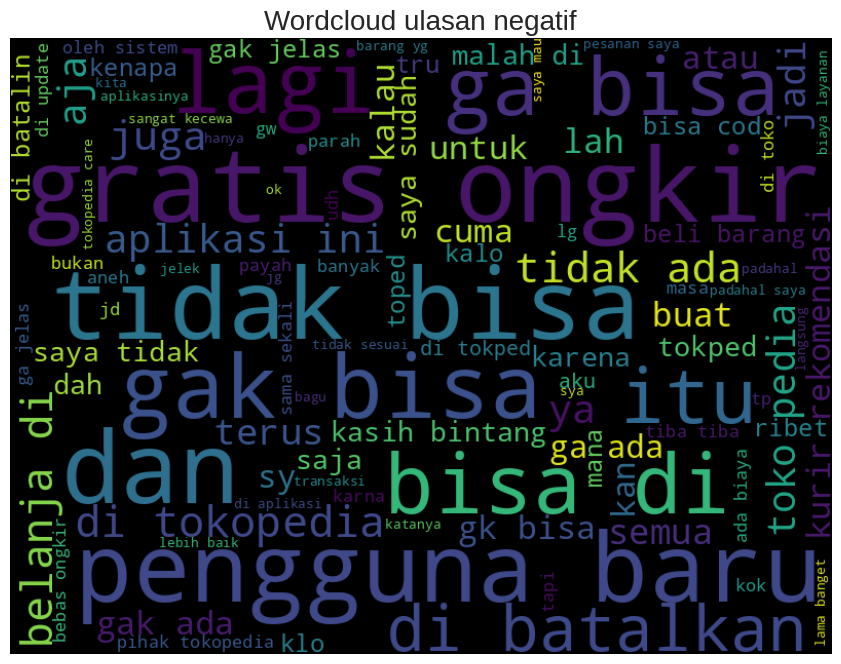

In [ ]:
# Split the dataframe into positive and negative based on the 'label' column
df_vis_pos = df[df['label'] == 1]  # Use label 1 for positive
df_vis_neg = df[df['label'] == 0]  # Use label 0 for negative

# Create WordCloud plot for positive reviews
txt_pos = ' '.join(rev for rev in df_vis_pos['ulasan'].astype(str)) # Use the actual review text
plt.figure(figsize=(15,8))
wordcloud_pos = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 600
            ).generate(txt_pos) # Generate from the positive text

plt.imshow(wordcloud_pos,interpolation = 'bilinear')
plt.axis('off')
plt.title(label="Wordcloud ulasan positif", fontsize=20)
plt.show()

# Create WordCloud plot for negative reviews
txt_neg = ' '.join(rev for rev in df_vis_neg['ulasan'].astype(str)) # Use the actual review text
plt.figure(figsize=(15,8))
wordcloud_neg = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 600
            ).generate(txt_neg) # Generate from the negative text

plt.imshow(wordcloud_neg,interpolation = 'bilinear')
plt.axis('off')
plt.title(label="Wordcloud ulasan negatif", fontsize=20)
plt.show()

insight dapat diambil:

Dominasi Sentimen Positif: Dengan melihat bar plot distribusi rating dan word cloud positif, terlihat jelas bahwa sentimen positif mendominasi dataset. Kata-kata seperti "bagus", "cepat", "sesuai", dan "mantap" yang menonjol dalam word cloud positif menunjukkan bahwa sebagian besar ulasan adalah apresiasi terhadap kualitas produk, kecepatan pengiriman, dan kesesuaian barang.

Fokus Keluhan pada Aspek Tertentu: Word cloud negatif, meskipun mungkin lebih kecil atau menunjukkan frekuensi kata yang lebih rendah dibandingkan word cloud positif (jika jumlah ulasan negatif lebih sedikit), tetap memberikan wawasan tentang jenis keluhan yang paling sering muncul. Kata-kata yang menonjol di sana (seperti "tidak", "lama", "rusak") akan menunjukkan masalah spesifik seperti keterlambatan pengiriman, barang yang tidak sesuai, atau kondisi barang yang buruk. Ini sangat berguna untuk mengidentifikasi area yang perlu diperbaiki.

Keterkaitan Rating dengan Kata Kunci: Ada korelasi yang jelas antara rating numerik dan kata kunci yang digunakan dalam ulasan. Rating tinggi (4 & 5) terkait erat dengan kata-kata positif, sementara rating rendah (1, 2, 3) terkait dengan kata-kata negatif. Proses pelabelan sentimen berdasarkan rating (di mana rating >= 4 menjadi Positif dan <= 3 menjadi Negatif) tampaknya cukup efektif dalam memisahkan ulasan berdasarkan kata-kata kunci yang dominan.

Potensi Ketidakseimbangan Dataset (Class Imbalance): Jika bar pada rating 4 dan 5 jauh lebih tinggi daripada rating 1, 2, dan 3, ini mengindikasikan potensi ketidakseimbangan kelas (class imbalance) antara sentimen positif dan negatif dalam dataset. Ini merupakan insight penting yang perlu dipertimbangkan saat melatih model klasifikasi, karena model mungkin cenderung lebih baik dalam memprediksi kelas yang mayoritas (Positif) daripada kelas yang minoritas (Negatif).

Secara keseluruhan, visualisasi ini memberikan pemahaman yang cepat dan intuitif tentang:

Seberapa positif atau negatif sentimen pelanggan secara keseluruhan.
Kata-kata kunci atau tema apa yang paling sering muncul dalam ulasan positif dan negatif.
Konfirmasi bahwa pelabelan sentimen berdasarkan rating cukup mencerminkan isi tekstual ulasan.
Identifikasi potensi masalah pada dataset, seperti ketidakseimbangan kelas.